In [1]:
import time
import yaml
import joblib

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

In [2]:
plt.rcParams["font.family"] = "Arial"

## Load Dataset

In [3]:
df_train = pd.read_parquet("../dataset/combined/undersampled/train-sel-10.parquet")
df_test = pd.read_parquet("../dataset/combined/full/test-sel-10.parquet")

In [4]:
X_train, y_train = df_train.drop(columns=["zone_id", "target"]), df_train["target"]
X_test, y_test = df_test.drop(columns=["zone_id", "target"]), df_test["target"]

## Training

In [5]:
best_params = yaml.safe_load(open("../dataset/models/best_params_random_forest.yml", "r"))
clf = Pipeline(steps=[
    ("scaler", MinMaxScaler()),
    ("classifier", RandomForestClassifier(**best_params))
])

st = time.time()
clf.fit(X_train, y_train)
dt = time.time() - st

# joblib.dump(clf, "../dataset/models/random_forest.joblib")
print("Time:", np.round(dt, 4))

Time: 45.4182


## Evaluation

In [6]:
st = time.time()
y_pred = clf.predict(X_test)
dt = time.time() - st

print("Time:", np.round(dt, 4))
print("MCC:", np.round(matthews_corrcoef(y_test, y_pred), 4))
print("Accuracy:", np.round(accuracy_score(y_test, y_pred), 4))
print("Precision:", np.round(precision_score(y_test, y_pred), 4))
print("Recall:", np.round(recall_score(y_test, y_pred), 4))
print("F1:", np.round(f1_score(y_test, y_pred), 4))

print(classification_report(y_test, y_pred))

Time: 4.9471
MCC: 0.8413
Accuracy: 0.9951
Precision: 0.7116
Recall: 0.9996
F1: 0.8314
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    624455
           1       0.71      1.00      0.83      7634

    accuracy                           1.00    632089
   macro avg       0.86      1.00      0.91    632089
weighted avg       1.00      1.00      1.00    632089



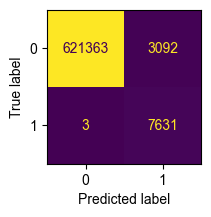

In [7]:
fig, ax = plt.subplots(figsize=(2, 2))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, colorbar=False)

## Inference

In [8]:
gpd_africa = gpd.read_file("../dataset/africa/shp/grid-sea-africa-zoned.shp")
gpd_australia = gpd.read_file("../dataset/australia/shp/grid-sea-australia-zoned.shp")

In [9]:
df_africa = pd.read_parquet("../dataset/combined/zonal/africa.parquet")
df_australia = pd.read_parquet("../dataset/combined/zonal/australia.parquet")

In [10]:
df_australia["ts"].max()

Timestamp('2023-11-30 00:00:00')

In [11]:
viscols = X_train.columns.tolist() + ["target", "ts", "zone_id"]
df_visualize = pd.concat([
    df_africa[df_africa["ts"].between("2023-01-01", "2023-11-30")][viscols].assign(country="africa"),
    df_australia[df_australia["ts"].between("2023-01-01", "2023-11-30")][viscols].assign(country="australia"),
], ignore_index=True)

df_visualize.head()

,sob_mean,sob_sum,fe_mean,fe_sum,so_sum,po4_mean,pbo_mean,pbo_sum,tob_mean,tob_sum,target,ts,zone_id,country
0,35.026119,105.078362,0.002330,0.002330,105.905983,0.230662,45.163334,135.490005,12.226613,36.679840,0,2023-05-22,126,africa
1,35.265999,35.265999,0.002189,0.004377,35.320118,0.240582,35.651169,35.651169,16.405302,16.405302,1,2023-05-22,135,africa
2,35.243912,105.731735,0.002399,0.002399,105.698517,0.230044,32.090046,96.270142,15.963172,47.889515,0,2023-05-22,169,africa
3,35.234768,70.469536,0.001953,0.001953,70.475334,0.236275,29.342491,58.684982,15.350924,30.701847,1,2023-05-22,178,africa
4,35.151783,210.910690,0.001516,0.001516,211.169373,0.208846,27.001066,162.006393,15.107807,90.646843,1,2023-05-22,188,africa


In [12]:
df_visualize["country"].unique()

array(['africa', 'australia'], dtype=object)

In [13]:
X_vis = df_visualize.drop(columns=["target", "ts", "zone_id", "country"])
y_vis = df_visualize["target"]
y_pred_vis = clf.predict(X_vis)

In [14]:
print("MCC:", np.round(matthews_corrcoef(y_vis, y_pred_vis), 4))
print("Accuracy:", np.round(accuracy_score(y_vis, y_pred_vis), 4))
print("Precision:", np.round(precision_score(y_vis, y_pred_vis), 4))
print("Recall:", np.round(recall_score(y_vis, y_pred_vis), 4))
print("F1:", np.round(f1_score(y_vis, y_pred_vis), 4))

print(classification_report(y_vis, y_pred_vis))

MCC: 0.8421
Accuracy: 0.9951
Precision: 0.7128
Recall: 0.9997
F1: 0.8322
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1479544
           1       0.71      1.00      0.83     18088

    accuracy                           1.00   1497632
   macro avg       0.86      1.00      0.91   1497632
weighted avg       1.00      1.00      1.00   1497632



In [15]:
def f_mcc(x):
    TP = x[1, 1]
    TN = x[0, 0]
    FP = x[0, 1]
    FN = x[1, 0]
    # FN = 0
    mcc = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return np.round(mcc, 4)

def f_f1(x):
    TP = x[1, 1]
    TN = x[0, 0]
    FP = x[0, 1]
    FN = x[1, 0]
    # FN = 0
    f1 = 2 * TP / (2 * TP + FP + FN)
    return np.round(f1, 4)

In [16]:
dv = df_visualize.copy()
dv["predicted"] = y_pred_vis
dv["proba"] = clf.predict_proba(X_vis)[:, 1]
dv["proba_log"] = clf.predict_log_proba(X_vis)[:, 1]
dv["ts_month"] = dv["ts"].dt.month

summary_whalemap = dv.pivot_table(index=["country", "ts_month"], columns=["target", "predicted"], aggfunc="size", fill_value=0)
summary_whalemap = summary_whalemap.reset_index()
summary_whalemap["mcc"] = summary_whalemap.apply(f_mcc, axis=1)
summary_whalemap["f1"] = summary_whalemap.apply(f_f1, axis=1)
summary_whalemap

/home/fahmi/research/thesis-tree/.venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:994: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


target       country ts_month       0       1           mcc      f1
predicted                           0    1  0     1                
0             africa        5   21767   94  0   180  0.8088  0.7930
1             africa        6  181481  694  0  1500  0.8253  0.8121
2             africa        7  225093  804  0  1860  0.8341  0.8223
3             africa        8  217913  697  0  1800  0.8477  0.8378
4             africa        9  181562  613  1  1499  0.8408  0.8300
5             africa       10   94354  377  0   780  0.8194  0.8054
6             africa       11   65389  194  0   540  0.8565  0.8477
7          australia        5   10695   81  0   219  0.8512  0.8439
8          australia        6   89284  516  1  1824  0.8801  0.8759
9          australia        7  110488  864  0  2263  0.8474  0.8397
10         australia        8  106914  846  0  2190  0.8460  0.8381
11         australia        9   89131  669  0  1825  0.8522  0.8451
12         australia       10   46227  469  2   947  0.8128  0.8008
13         australia       11   31959  369  1   656  0.7948  0.7800

In [17]:
dv[["country", "target"]].value_counts().sort_index()

country    target
africa     0         991032
           1           8160
australia  0         488512
           1           9928
Name: count, dtype: int64

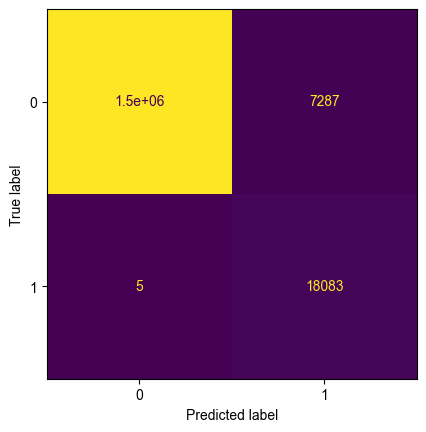

In [18]:
ConfusionMatrixDisplay.from_predictions(y_vis, y_pred_vis, colorbar=False)

In [19]:
df_visualize["ts"]

0         2023-05-22
1         2023-05-22
2         2023-05-22
3         2023-05-22
4         2023-05-22
             ...    
1497627   2023-11-30
1497628   2023-11-30
1497629   2023-11-30
1497630   2023-11-30
1497631   2023-11-30
Name: ts, Length: 1497632, dtype: datetime64[ns]

## Save Geojson

In [21]:
df_sel = dv[((dv["target"] == 1) | (dv["predicted"] == 1)) & (dv["country"] == "australia")].copy().drop(columns=["country"])
df_sel = df_sel.groupby(["zone_id", "ts_month", "target", "predicted"]).mean().reset_index()
df_sel

,zone_id,ts_month,target,predicted,sob_mean,sob_sum,fe_mean,fe_sum,so_sum,po4_mean,pbo_mean,pbo_sum,tob_mean,tob_sum,ts,proba,proba_log
0,433,9,0,1,34.705193,416.462311,0.000395,0.000395,425.076000,0.130867,2320.887177,27850.645996,2.300348,27.604181,2023-09-18 09:00:00.000000000,0.608841,-0.497667
1,433,10,0,1,34.711548,416.538581,0.000427,0.000427,425.126897,0.134682,2320.879038,27850.548528,2.315481,27.785775,2023-10-14 12:55:23.076923136,0.601689,-0.508765
2,530,7,0,1,34.721002,416.652023,0.000274,0.000274,425.890293,0.132705,2616.322124,31395.865646,1.831339,21.976071,2023-07-20 00:00:00.000000000,0.673128,-0.403420
3,530,8,0,1,34.725766,416.709198,0.000305,0.000305,424.859694,0.137223,2616.334521,31396.014141,1.854974,22.259684,2023-08-17 17:16:48.000000000,0.718049,-0.335755
4,530,9,0,1,34.732561,416.790729,0.000347,0.000347,424.877319,0.134155,2616.342285,31396.107812,1.941309,23.295711,2023-09-08 14:24:00.000000000,0.673171,-0.409809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,4714,9,0,1,35.443333,212.660004,0.000930,0.000930,212.704773,0.231557,84.706856,508.241150,14.000310,84.001862,2023-09-29 00:00:00.000000000,0.513821,-0.665880
877,4714,10,0,1,35.450888,212.705330,0.000836,0.000836,212.701721,0.228446,84.726837,508.361023,14.093060,84.558365,2023-10-02 12:00:00.000000000,0.526016,-0.642482
878,4714,11,0,1,35.418686,212.512115,0.000897,0.000897,213.277679,0.203544,84.620789,507.724731,13.835282,83.011692,2023-11-25 12:00:00.000000000,0.541870,-0.614071
879,4721,9,0,1,35.457333,212.744001,0.001198,0.001198,212.723455,0.222617,79.805481,478.832876,14.093495,84.560970,2023-09-25 12:00:00.000000000,0.518022,-0.657987


In [22]:
# gdf_sel = gpd_africa[["ZONE_ID", "geometry"]].copy().rename(columns={"ZONE_ID": "zone_id"})
gdf_sel = gpd_australia[["ZONE_ID", "geometry"]].copy().rename(columns={"ZONE_ID": "zone_id"})
gdf_sel

,zone_id,geometry
0,1,"POLYGON ((111.27449 -12.15167, 111.27449 -12.4..."
1,2,"POLYGON ((111.27449 -12.45167, 111.27449 -12.7..."
2,3,"POLYGON ((111.27449 -12.75167, 111.27449 -13.0..."
3,4,"POLYGON ((111.27449 -13.05167, 111.27449 -13.3..."
4,5,"POLYGON ((111.27449 -13.35167, 111.27449 -13.6..."
...,...,...
4793,4794,"POLYGON ((144.46291 -39.15167, 144.46291 -39.4..."
4794,4795,"POLYGON ((144.46291 -39.45167, 144.46291 -39.7..."
4795,4796,"POLYGON ((144.46291 -39.75167, 144.46291 -40.0..."
4796,4797,"POLYGON ((144.46291 -40.05167, 144.46291 -40.3..."


In [23]:
df_con = gpd.GeoDataFrame(pd.merge(df_sel, gdf_sel, on="zone_id")).drop(columns=["ts"])
df_con.head()

,zone_id,ts_month,target,predicted,sob_mean,sob_sum,fe_mean,fe_sum,so_sum,po4_mean,pbo_mean,pbo_sum,tob_mean,tob_sum,proba,proba_log,geometry
0,433,9,0,1,34.705193,416.462311,0.000395,0.000395,425.076000,0.130867,2320.887177,27850.645996,2.300348,27.604181,0.608841,-0.497667,"POLYGON ((112.47449 -27.75167, 112.47449 -28.0..."
1,433,10,0,1,34.711548,416.538581,0.000427,0.000427,425.126897,0.134682,2320.879038,27850.548528,2.315481,27.785775,0.601689,-0.508765,"POLYGON ((112.47449 -27.75167, 112.47449 -28.0..."
2,530,7,0,1,34.721002,416.652023,0.000274,0.000274,425.890293,0.132705,2616.322124,31395.865646,1.831339,21.976071,0.673128,-0.403420,"POLYGON ((112.77449 -28.35167, 112.77449 -28.6..."
3,530,8,0,1,34.725766,416.709198,0.000305,0.000305,424.859694,0.137223,2616.334521,31396.014141,1.854974,22.259684,0.718049,-0.335755,"POLYGON ((112.77449 -28.35167, 112.77449 -28.6..."
4,530,9,0,1,34.732561,416.790729,0.000347,0.000347,424.877319,0.134155,2616.342285,31396.107812,1.941309,23.295711,0.673171,-0.409809,"POLYGON ((112.77449 -28.35167, 112.77449 -28.6..."


<Axes: >

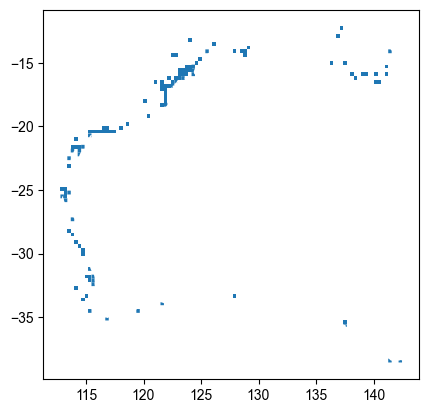

In [24]:
df_con[df_con["ts_month"] == 6].plot()

In [25]:
df_con.to_file("australia.json", driver="GeoJSON")

### Visualize Maps

In [21]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [22]:
probas = clf.predict_proba(X_vis)
probas[probas == 0] = np.finfo(float).eps

In [23]:
df_pred = df_visualize[["zone_id", "country", "target"]].copy()
df_pred["proba"] = np.log(probas[:, 1])
df_pred["classified"] = clf.predict(X_vis)

df_pred = df_pred.groupby(["country", "zone_id"]).max().reset_index()
df_pred.head()

,country,zone_id,target,proba,classified
0,africa,126,0,-1.949983,0
1,africa,135,1,0.000000,1
2,africa,169,0,-1.359027,0
3,africa,178,1,0.000000,1
4,africa,188,1,0.000000,1


In [24]:
df_pred[["country", "target"]].value_counts().sort_index()

country    target
africa     0         7287
           1           60
australia  0         3592
           1           73
Name: count, dtype: int64

In [25]:
df_pred[["country", "classified"]].value_counts().sort_index()

country    classified
africa     0             7243
           1              104
australia  0             3560
           1              105
Name: count, dtype: int64

In [26]:
def plot_map(df):
    fig, axes = plt.subplots(1, 2)
    axes[0].set_ylabel("Latitude")
    axes[0].set_xlabel("Longitude")
    df.plot(column="target", ax=axes[0])

    axes[1].set_ylabel("Latitude")
    axes[1].set_xlabel("Longitude")
    df.plot(column="classified", ax=axes[1])

    fig.tight_layout()
    plt.show()

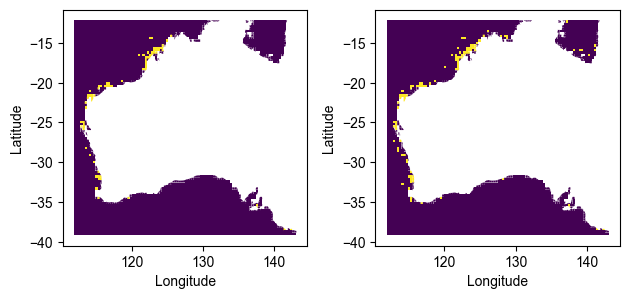

In [27]:
df_corr_aus = df_pred[df_pred["country"] == "australia"].copy()
gpd_res_aus = gpd_australia.merge(df_corr_aus, left_on="ZONE_ID", right_on="zone_id", how="left").drop(columns=["country", "zone_id"])
# gpd_res_aus.to_file("../dataset/reclassify/australia_classif_2023.shp")

plot_map(gpd_res_aus)

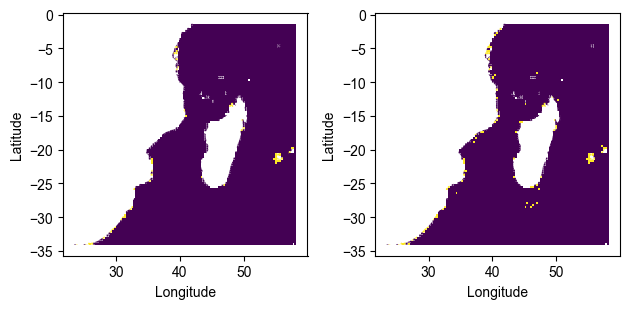

In [28]:
df_corr_africa = df_pred[df_pred["country"] == "africa"].copy()
gpd_res_africa = gpd_africa.merge(df_corr_africa, left_on="ZONE_ID", right_on="zone_id", how="left").drop(columns=["country", "zone_id"])
# gpd_res_africa.to_file("../dataset/reclassify/africa_classif_2023.shp")

plot_map(gpd_res_africa)

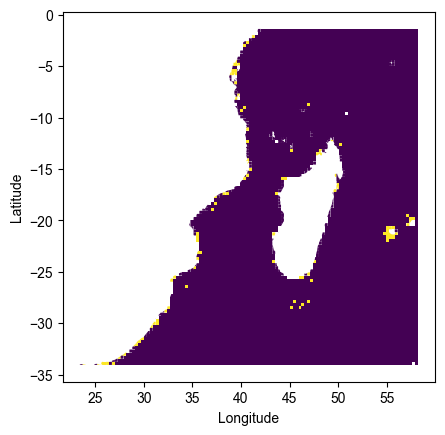

In [29]:
fig, ax = plt.subplots()
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
# gpd_res_aus.plot(column="classified", ax=ax)
gpd_res_africa.plot(column="classified", ax=ax)
fig.savefig("map.pdf", dpi=300)

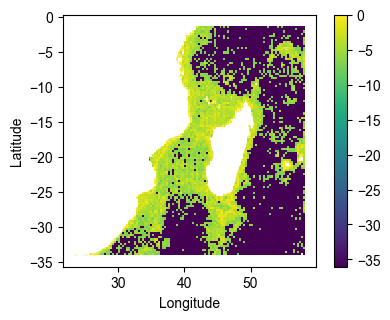

In [30]:
fig, ax = plt.subplots(figsize=(4, 4))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
# gpd_res_aus.plot(column="proba", ax=ax, legend=True, cax=cax)
gpd_res_africa.plot(column="proba", ax=ax, legend=True, cax=cax)

fig.tight_layout()
fig.savefig("proba.pdf", dpi=300)
plt.show()